# Финальный проект


#### Выполнил Ким Антон 
#### В рамках курса "Введение в машинное обучение" от Высшей школы экономики

## Предсказание исхода матчей в игре DOTA 2
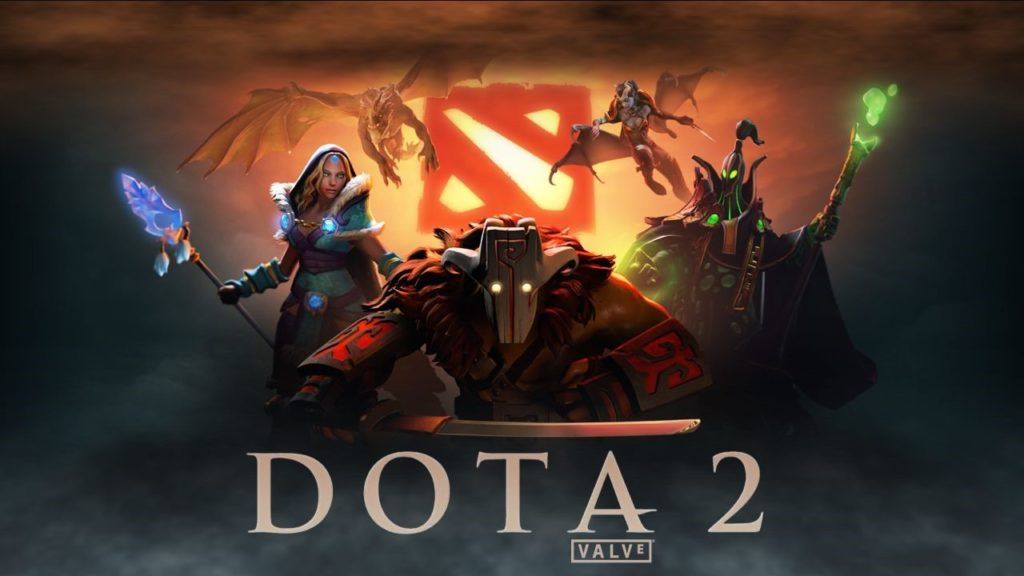

In [12]:
import pandas as pd 
import numpy as np
%matplotlib inline 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('data/week_7_features.csv', index_col='match_id')

## Подход 1: градиентный бустинг "в лоб"

In [3]:
print(f" {'№':^3} | {'COLUMNS:':^30} | {'GAPS:':^10} | {'%':^5} ")
print(f"{'-'*60}")
j = 1 
for i in train_df.columns:
    if train_df[i].isna().sum() > 0:
      print(f" {j:^3} | {i:^30} | {train_df[i].isna().sum():^10} | {np.round(train_df[i].isna().mean(), decimals=4):^5} ")        
      j+=1


  №  |            COLUMNS:            |   GAPS:    |   %   
------------------------------------------------------------
  1  |        first_blood_time        |   19553    | 0.2011 
  2  |        first_blood_team        |   19553    | 0.2011 
  3  |      first_blood_player1       |   19553    | 0.2011 
  4  |      first_blood_player2       |   43987    | 0.4524 
  5  |      radiant_bottle_time       |   15691    | 0.1614 
  6  |      radiant_courier_time      |    692     | 0.0071 
  7  |  radiant_flying_courier_time   |   27479    | 0.2826 
  8  |    radiant_first_ward_time     |    1836    | 0.0189 
  9  |        dire_bottle_time        |   16143    | 0.166 
 10  |       dire_courier_time        |    676     | 0.007 
 11  |    dire_flying_courier_time    |   26098    | 0.2684 
 12  |      dire_first_ward_time      |    1826    | 0.0188 


### 1. Признаки с пропусками в данных
##### Как видно из таблицы выше, у нас есть `12` признаков в которых отсутствуют значения
<ul>
    <li><b>first_blood_time</b>: игровое время первой крови</li>
    <li><b>first_blood_team</b>: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)</li>
    <li><b>first_blood_player1</b>: игрок, причастный к событию</li>
    <li><b>first_blood_player2</b>: второй игрок, причастный к событию</li>
    <li><b>radiant_bottle_time</b>: время первого приобретения командой <em>Света</em> предмета "bottle"</li>
    <li><b>radiant_courier_time</b>: время приобретения командой <em>Света</em> предмета "courier"</li>
    <li><b>radiant_flying_courier_time</b>: время приобретения командой <em>Света</em> предмета "flying_courier"</li>
    <li><b>radiant_first_ward_time</b>: время установки командой <em>Света</em> первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля</li>
    <li><b>dire_bottle_time</b>: время первого приобретения командой <em>Тьмы</em> предмета "bottle"</li>
    <li><b>dire_courier_time</b>: время приобретения командой <em>Тьмы</em> предмета "courier"</li>
    <li><b>dire_flying_courier_time</b>: время приобретения командой <em>Тьмы</em> предмета "flying_courier"</li>
    <li><b>dire_first_ward_time</b>: время первого приобретения командой <em>Тьмы</em> предмета "bottle"</li>
</ul>


Эти признаки все <strong>связаны со временем</strong>, так как мы берем только <b>первые 5 минут</b> игры поэтому они предсказуемы.<br> 
Вполне возможно, что, например <u><em>первое убийство (first_blood_time)</em></u> могло быть позже. Тогда в рамках этого времени этого события не случилось, поэтому тут стоит пропуск, а так как признаки: <u><em>first_blood_player1 и first_blood_player2</em></u> напрямую зависят от этого события, они также будут иметь пропуск. <br>
Для начала попробуем просто <u>заполнить все пропуски нулями</u>

In [4]:
X_train = train_df.copy()
for i in X_train.columns:
    if X_train[i].isna().sum() > 0:
        X_train[i] = X_train[i].fillna(0)

### 2. Наша целевая переменная 
##### называется <u>radiant_win</u>
Она бинарная (имеет два значения):
<ul>
    <li>1 - победу одержала команда Света</li>
    <li>0 - победу одержала команда Тьмы</li>
</ul>

In [5]:
y = X_train['radiant_win']
X_train.drop(['radiant_win', 'tower_status_radiant', 'tower_status_dire', 
                'barracks_status_radiant', 'barracks_status_dire', 
                 'duration'], axis=1, inplace=True)

### 3. Cross Validation
Проведем кросс-валидацию для 30-ти деревьев и замерим качество и время

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score

In [7]:
model = GradientBoostingClassifier(n_estimators=30, random_state=200)
cv = KFold(shuffle=True, random_state=200)

In [8]:
%%time
results = cross_val_score(model, X_train, y=y, cv=cv, scoring='roc_auc', n_jobs=-1)
np.mean(results)

Wall time: 1min 13s


0.6899840856308699

#### Как видно выше, Градиентный бустинг "из коробки" уже дает непрохой результат:
<ul>
    <li>Качество - примерно 69%</li>
    <li>Время - приблизительно 40 - 50 сек </li>
</ul>

### 4. Попробуем его улучшить 

Объединим признаки связанные с первым убийством в два бинарных
<ul>
    <li><b>r_FB</b> - принимает значение <b>1</b> если команда <u>Света</u> совершило первое убиство за первые 5 минут, иначе <b>0</b></li>
    <li><b>d_FB</b> - принимает значение <b>1</b> если команда <u>Тьмы</u>, иначе <b>0</b></li>
</ul>
Эти признаки позволяют обрабатывать все три случая:
<ul>
    <li><b>Когда убил Свет</b> - 1 0</li>
    <li><b>Когда убила Тьма</b> - 0 1</li>
    <li><b>Когда никто не убивал</b> - 0 0</li>
</ul>
И также немного понизит размерность выборки

In [9]:
X_train['d_FB'] = train_df['first_blood_team'].apply(lambda x: 1 if x==1 else 0)
X_train['r_FB'] = train_df['first_blood_team'].apply(lambda x: 1 if x==0 else 0)
X_train.drop(['first_blood_player1', 'first_blood_player2', 
               'first_blood_time','first_blood_team'], axis=1, inplace=True)

Также попробует найти общее золото и счетчик убийств
<ul>
    <li><b>rad_total_gold</b> - просуммированное значение золота у 5 игроков команды <u>Света</u> за первые 5 минут</li>
    <li><b>rad_total_gold</b> - просуммированное значение золота у 5 игроков команды <u>Тьмы</u></li>
    <li><b>rad_total_kills</b> - просуммированное значение убийств у 5 игроков команды <u>Света</u> за первые 5 минут</li>
    <li><b>rad_total_kills</b> - просуммированное значение убийств у 5 игроков команды <u>Тьмы</u></li>
</ul>
Думаю что это создаст довольно мощные признаки и неплохо понизит размерность выборки

In [10]:
rad = []
dire = []
for i in X_train.columns:
    if i.startswith('r') and 'gold' in i: 
        rad.append(i)
    if i.startswith('d') and 'gold' in i:
        dire.append(i)
X_train['rad_total_gold'] = X_train[rad].sum(axis=1)
X_train['dire_total_gold'] = X_train[dire].sum(axis=1)
X_train.drop(rad, axis=1, inplace=True)
X_train.drop(dire, axis=1, inplace=True)

In [11]:
rad = []
dire = []
for i in X_train.columns:
    if i.startswith('r') and 'kills' in i: 
        rad.append(i)
    if i.startswith('d') and 'kills' in i:
        dire.append(i)
X_train['rad_total_kills'] = X_train[rad].sum(axis=1)
X_train['dire_total_kills'] = X_train[dire].sum(axis=1)
X_train.drop(rad, axis=1, inplace=True)
X_train.drop(dire, axis=1, inplace=True)

#### Еще раз проведем кросс валидацию, но теперь попробуем построить кривую обучения
Проверем качество на 5-ти моделях: 10, 20, ... , 50 деревьев <br>
Замерим время и качество на каждой

In [12]:
%%time
res = []
for i in np.arange(10, 60, 10):
    model = GradientBoostingClassifier(n_estimators=i, random_state=200)
    time = pd.datetime.now()
    mean = cross_val_score(model, X_train, y=y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    print(f"{i:^5} | {mean:^10} | {(pd.datetime.now() - time).seconds}")
    res.append(mean)

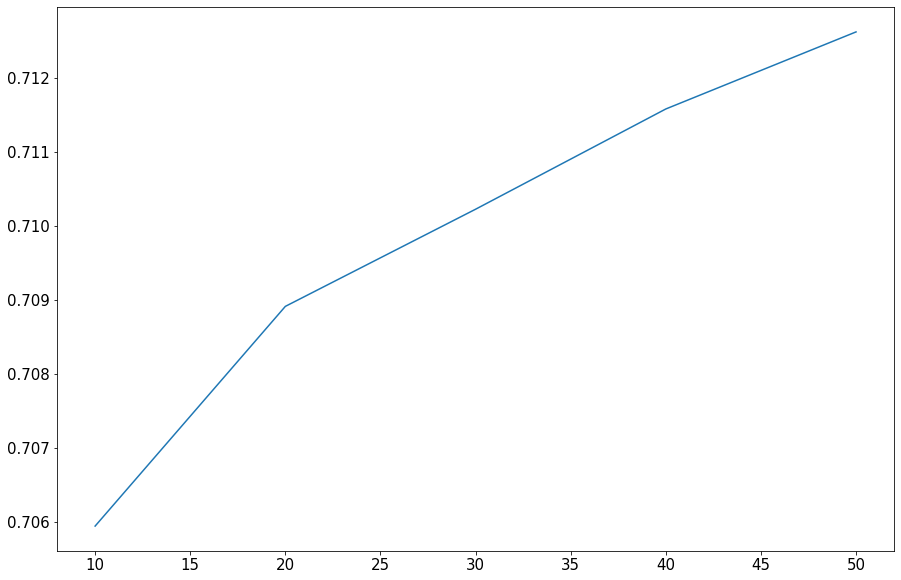

In [13]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15, 10))
plt.plot(np.arange(10, 60, 10), res);

#### Наши небольшие изменения определенно пошли на пользу
<b>Качество повысилось, а время уменьшилось</b> <br>
Также из графика можно сразу сказать, что модель еще не достигла своего предела, и <u>увеличение количества деревьев может положительно сказаться на качестве</u>

## Подход 2: логистическая регрессия

Так как логистическая регрессия это линейный метод, ему необходима <u>дополнителная обработка</u>:<br>
<ul>
    <li><b>Маштабирование</b></li>
    <li><b>Кодирование категориальных переменных</b></li>
    <li><b>Проверка на выбросы</b></li>
</ul>

In [13]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X = scale.fit_transform(X_train)

Попробуем обучиться на дефолтных параметрах

In [14]:
%%time
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=200, n_jobs=-1)
cross_val_score(model, X, y=y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()

Wall time: 3.93 s


0.7164982920989317

Довольно высокое качество и скорость

#### Теперь попробуем подобрать лучший параметр C регуляции

In [14]:
%%time
res = []
for i in np.arange(0.1, 1.1, 0.1):
    model = LogisticRegression(C=i, random_state=200, n_jobs=-1)
    time = pd.datetime.now()
    mean = cross_val_score(model, X, y=y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    print(f"{i:^5} | {mean:^10} | {(pd.datetime.now() - time).seconds}")
    res.append(mean)

 0.1  | 0.7165017853626338 | 2
 0.2  | 0.7164999594284239 | 1
0.30000000000000004 | 0.7164996946008207 | 1
 0.4  | 0.7164991967070264 | 2
 0.5  | 0.7164990208788409 | 1
 0.6  | 0.7164987538973593 | 1
0.7000000000000001 | 0.7164982560850153 | 1
 0.8  | 0.7164983598971881 | 1
 0.9  | 0.7164983366074423 | 1
 1.0  | 0.7164982920989317 | 1
Wall time: 19.6 s


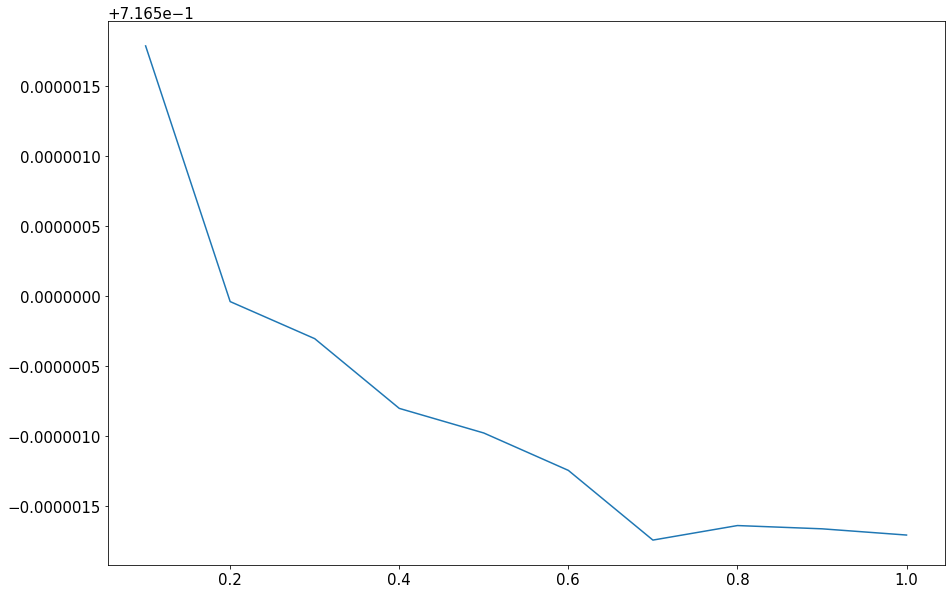

In [15]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15, 10))
plt.plot(np.arange(0.1, 1.1, 0.1), res);

Как видно из графика, лучший 0.1

#### Избавимся от категориальных признаков

In [15]:
rad = []
dire = []
for i in X_train.columns:
    if i.startswith('r') and 'hero' in i: 
        rad.append(i)
    if i.startswith('d') and 'hero' in i:
        dire.append(i)
X_train.drop(rad, axis=1, inplace=True)
X_train.drop(dire, axis=1, inplace=True)
X_train.drop('lobby_type', axis=1, inplace=True)

In [16]:
X = scale.fit_transform(X_train)
model = LogisticRegression(C=0.1, random_state=200, n_jobs=-1)
cross_val_score(model, X, y=y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()

0.7165868604266027

Качество практически не изменилось, попробуем мешок слов

In [23]:
train_df[['r1_hero', 'r2_hero','r3_hero','r4_hero','r5_hero',
          'd1_hero','d2_hero','d3_hero','d4_hero','d5_hero']].max()

r1_hero    112
r2_hero    112
r3_hero    112
r4_hero    112
r5_hero    112
d1_hero    112
d2_hero    112
d3_hero    112
d4_hero    112
d5_hero    112
dtype: int64

In [35]:
X_pick = np.zeros((X_train.shape[0], 112))
for i, match_id in enumerate(X_train.index):
    for p in np.arange(5):
        X_pick[i, train_df.loc[match_id, f'r{p+1}_hero']-1] = 1
        X_pick[i, train_df.loc[match_id, f'd{p+1}_hero']-1] = -1

In [37]:
data = np.hstack((X, X_pick))

In [38]:
%%time 
model = LogisticRegression(C=0.1, random_state=200, n_jobs=-1)
cross_val_score(model, data, y=y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()

Wall time: 15.6 s


0.7519088723301509

Качество стало значительно выше

## Финал
### Мы нашли лучшую модель и признаки, теперь попробуем предсказать тестовую выборку

In [1]:
import pandas as pd
import numpy as np
train_df = pd.read_csv('data/week_7_features.csv', index_col='match_id')
test_df = pd.read_csv('data/week_7_features_test.csv', index_col='match_id')

In [2]:
X_train = train_df.copy()
X_test = test_df.copy()
for i in test_df.columns:
    if X_train[i].isna().sum() > 0:
        X_train[i] = X_train[i].fillna(0)
    if X_test[i].isna().sum() > 0:
        X_test[i] = X_test[i].fillna(0)

In [3]:
y = X_train['radiant_win']
X_train.drop(['radiant_win', 'tower_status_radiant', 'tower_status_dire', 
                'barracks_status_radiant', 'barracks_status_dire', 
                 'duration'], axis=1, inplace=True)

In [4]:
X_train['d_FB'] = train_df['first_blood_team'].apply(lambda x: 1 if x==1 else 0)
X_train['r_FB'] = train_df['first_blood_team'].apply(lambda x: 1 if x==0 else 0)
X_train.drop(['first_blood_player1', 'first_blood_player2', 
               'first_blood_time','first_blood_team'], axis=1, inplace=True)

X_test['d_FB'] = test_df['first_blood_team'].apply(lambda x: 1 if x==1 else 0)
X_test['r_FB'] = test_df['first_blood_team'].apply(lambda x: 1 if x==0 else 0)
X_test.drop(['first_blood_player1', 'first_blood_player2', 
               'first_blood_time','first_blood_team'], axis=1, inplace=True)

In [5]:
rad = []
dire = []
for i in X_test.columns:
    if i.startswith('r') and 'gold' in i: 
        rad.append(i)
    if i.startswith('d') and 'gold' in i:
        dire.append(i)
X_test['rad_total_gold'] = X_test[rad].sum(axis=1)
X_test['dire_total_gold'] = X_test[dire].sum(axis=1)
X_test.drop(rad, axis=1, inplace=True)
X_test.drop(dire, axis=1, inplace=True)

X_train['rad_total_gold'] = X_train[rad].sum(axis=1)
X_train['dire_total_gold'] = X_train[dire].sum(axis=1)
X_train.drop(rad, axis=1, inplace=True)
X_train.drop(dire, axis=1, inplace=True)

In [6]:
rad = []
dire = []
for i in X_test.columns:
    if i.startswith('r') and 'kills' in i: 
        rad.append(i)
    if i.startswith('d') and 'kills' in i:
        dire.append(i)
X_test['rad_total_kills'] = X_test[rad].sum(axis=1)
X_test['dire_total_kills'] = X_test[dire].sum(axis=1)
X_test.drop(rad, axis=1, inplace=True)
X_test.drop(dire, axis=1, inplace=True)

X_train['rad_total_kills'] = X_train[rad].sum(axis=1)
X_train['dire_total_kills'] = X_train[dire].sum(axis=1)
X_train.drop(rad, axis=1, inplace=True)
X_train.drop(dire, axis=1, inplace=True)

In [7]:
rad = []
dire = []
for i in X_test.columns:
    if i.startswith('r') and 'hero' in i: 
        rad.append(i)
    if i.startswith('d') and 'hero' in i:
        dire.append(i)
X_test.drop(rad, axis=1, inplace=True)
X_test.drop(dire, axis=1, inplace=True)
X_test.drop('lobby_type', axis=1, inplace=True)

X_train.drop(rad, axis=1, inplace=True)
X_train.drop(dire, axis=1, inplace=True)
X_train.drop('lobby_type', axis=1, inplace=True)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

train_scale = X_train.copy()

train_bag = np.zeros((X_train.shape[0], 112))
for i, match_id in enumerate(X_train.index):
    for p in np.arange(5):
        train_bag[i, train_df.loc[match_id, f'r{p+1}_hero']-1] = 1
        train_bag[i, train_df.loc[match_id, f'd{p+1}_hero']-1] = -1

test_scale = X_test.copy()

test_bag = np.zeros((X_test.shape[0], 112))
for i, match_id in enumerate(X_test.index):
    for p in np.arange(5):
        test_bag[i, test_df.loc[match_id, f'r{p+1}_hero']-1] = 1
        test_bag[i, test_df.loc[match_id, f'd{p+1}_hero']-1] = -1

scale = StandardScaler()
train_scale = scale.fit_transform(train_scale)
test_scale = scale.transform(test_scale)

train_data = np.hstack((train_scale, train_bag))
test_data = np.hstack((test_scale, test_bag))

In [9]:
%%time
model = LogisticRegression(C=0.1, n_jobs=-1)
model.fit(train_data, y)

Wall time: 1min 17s


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
pred = model.predict_proba(test_data)
model.predict_proba

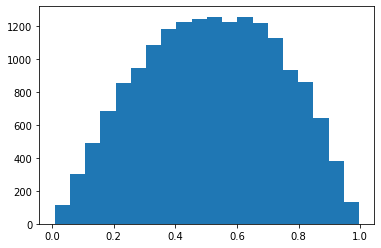

In [15]:
plt.hist(pred, bins=20);

In [23]:
pred[0]

array([0.17725804, 0.82274196])